In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style('darkgrid')
%matplotlib inline

In [2]:
# data prep and model-tuning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, QuantileTransformer
from scipy.stats import shapiro
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

# types of models we'll fit
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import pickle
from copy import deepcopy

## Our Data

In [3]:
DATA = '../data/processed/training_data_annual.csv'
df = pd.read_csv(DATA)
df = df.dropna()
print('{:,d} samples'.format(len(df)))
print('Columns:', df.columns.values)

4,721 samples
Columns: ['uuid' 'lidar_year' 'lat' 'lon' 'orig_id' 'source' 'meas_yr' 'ecoregion3'
 'agency' 'plot_size_ac' 'num_returns' 'strat0_return-proportion'
 'strat1_return-proportion' 'strat2_return-proportion'
 'strat3_return-proportion' 'strat4_return-proportion'
 'strat5_return-proportion' 'strat0_intensity-median'
 'strat1_intensity-median' 'strat2_intensity-median'
 'strat3_intensity-median' 'strat4_intensity-median'
 'strat5_intensity-median' 'height_05-percentile' 'height_25-percentile'
 'height_50-percentile' 'height_75-percentile' 'height_95_percentile'
 'height_max' 'cover' 'lidar_acq' 'potential_volume' 'stddev_height'
 'surface_area_ratio' 'surface_volume' 'surface_volume_ratio' 'aspect'
 'elevation' 'overall_curvature' 'plan_curvature' 'profile_curvature'
 'slope' 'solar_radiation_index' 'mat' 'mwmt' 'mcmt' 'td' 'map' 'msp'
 'ahm' 'shm' 'dd_0' 'dd5' 'dd_18' 'dd18' 'nffd' 'bffp' 'effp' 'ffp' 'pas'
 'emt' 'ext' 'eref' 'cmd' 'rh' 'green' 'blue' 'red' 'nir' 'endvi' 'nd

## Filter out some of the training data
We can exclude some of the training data based on how far separated the inventory data (interpolated using FVS simulations) is from the year the lidar was collected. Similarly, we can screen out training examples that had relatively low density of lidar returns.

In [4]:
df['year_diff'] = abs(df['fvs_year'] - df['lidar_year']).astype(int)
df = df.loc[df['year_diff'] < 10]
df = df.loc[df['returns_per_m2'] >= 4.0]

## Inspect how many samples we have for different years, regions, etc.

In [5]:
df.groupby(by=['lidar_year'])[['uuid']].count().rename({'uuid':'count'}, axis=1)

,count
lidar_year,
2006,191
2008,857
2009,113
2010,21
2011,161
2012,720
2013,269
2014,368
2015,680


In [6]:
pd.pivot_table(df, 
               values='uuid', 
               aggfunc='count', 
               index=['meas_yr'], 
               columns=['lidar_year'], 
               fill_value=0)

lidar_year,2006,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
meas_yr,,,,,,,,,,,,
2010,0,475,0,0,0,4,0,2,7,0,0,0
2011,0,377,0,0,0,1,0,2,3,0,0,0
2013,168,0,18,0,37,466,54,6,11,14,28,2
2014,5,0,60,2,28,132,45,50,44,99,40,1
2015,18,4,5,0,55,18,13,16,217,114,25,6
2016,0,1,18,15,26,45,90,59,284,77,36,26
2017,0,0,9,2,12,44,43,182,58,104,51,0
2018,0,0,3,2,3,10,24,51,56,196,11,0


In [7]:
ecoreg_counts = df.groupby(by=['ecoregion3'])[['uuid']].count()
ecoreg_counts

,uuid
ecoregion3,
blue_mountains,108
cascades,747
coast_range,1809
columbia_plateau,14
eastern_cascades_slopes_and_foothills,409
klamath_mountains_california_high_north_coast_range,323
north_cascades,505
northern_rockies,103
puget_lowland,149


## Available features
First, we'll use one-hot encoding for categorical features

In [8]:
# convert agency, ecoregion, and lidar acquisition into one-hot encoded set of variables
df = pd.get_dummies(df, prefix='agency', columns=['agency'])
# df = pd.get_dummies(df, prefix='eco', columns=['ecoregion3'])
# df = pd.get_dummies(df, prefix='acq', columns=['lidar_acq'])

The different types of predictor variables we can use to predict a forest attribute, including climate, lidar-derived, soil, and satellite imagery.

In [9]:
CLIM_COLS = ['mat', 'mwmt', 'mcmt', 'td', 'map', 'msp', 'ahm', 'shm', 
             'dd_0', 'dd5', 'dd_18', 'dd18', 'nffd', 'bffp', 'effp', 
             'ffp', 'pas', 'emt', 'ext', 'eref', 'cmd', 'rh']
LIDAR_COLS = ['returns_per_m2', 'strat0_return-proportion',
       'strat1_return-proportion', 'strat2_return-proportion',
       'strat3_return-proportion', 'strat4_return-proportion',
       'strat5_return-proportion', 'strat0_intensity-median',
       'strat1_intensity-median', 'strat2_intensity-median',
       'strat3_intensity-median', 'strat4_intensity-median',
       'strat5_intensity-median', 'height_05-percentile',
       'height_25-percentile', 'height_50-percentile', 'height_75-percentile',
       'height_95_percentile', 'height_max', 'cover', 'potential_volume',
       'stddev_height', 'surface_area_ratio', 'surface_volume',
       'surface_volume_ratio', 'aspect', 'elevation', 'overall_curvature',
       'plan_curvature', 'profile_curvature', 'slope', 'solar_radiation_index']

SOIL_COLS = ['bulk_dens', 'soil_depth', 'pct_clay_surf', 'pct_rock_surf', 'pct_sand_surf']

LANDSAT_COLS = ['green', 'blue', 'red', 'nir', 'endvi', 'ndvi', 'savi',
                'swir1', 'swir2', 'wetness', 'greenness', 'brightness']

AGENCY_COLS = ['agency_BLM', 'agency_USFS', 'agency_WADNR']

# ECOREGIONS = [col for col in df.columns if col.startswith('eco_')]

## Selecting initial features and targets
This is the first step in determining what features we want to use, and what we want to predict. Later, we can still apply some procedures to choose a subset of these features to make simpler models.

In [10]:
X_COLS = LIDAR_COLS + ['plot_size_ac', 'ecoregion3', 'distance_to_water_m'] + LANDSAT_COLS + CLIM_COLS
Y_COLS = ['TRUE_FIR', 'OTHER_HARDWOOD', 'MAPLE', 'OAK', 'DOUGLAS_FIR', 'SPRUCE', 'CEDAR',
          'PONDEROSA_PINE', 'OTHER_SOFTWOOD', 'LODGEPOLE_PINE', 'HEMLOCK', 'RED_ALDER',
          'TANOAK', 'JUNIPER', 'LARCH']

In [11]:
ba_prop = df[Y_COLS].values / (df['ba'].values.reshape(-1,1) + 1e-9)
abund = (ba_prop > 0.33)*1
# create a dataframe that has abundant species groups indicated with 1s
abund_df = pd.DataFrame(data=abund, columns=Y_COLS)
# group unique combinations of abundant species together and generate a unique ID for each
type_lookup = abund_df.groupby(Y_COLS).size().reset_index().reset_index().rename({0:'count', 'index':'forest_type_id'},axis=1).set_index(Y_COLS)
type_lookup['forest_type_id'] = type_lookup['forest_type_id'] + 1
type_lookup['weight'] = 1 / type_lookup['count']

# forest types that have less than 3 observations will be combined into "other"
type_lookup.loc[type_lookup['count'] < 3, 'forest_type_id'] = 999

# assign the unique forest type id to the main dataframe
df['forest_type_id'] = type_lookup.reindex(abund_df[Y_COLS])['forest_type_id'].values
df['weight'] = type_lookup.reindex(abund_df[Y_COLS])['weight'].values

## Split the data into training and testing sets
Since some plot_ids have multiple observations, we want all observations for each plot_id to fall entirely in train_set or entirely the training or testing sets because these samples are definitely not independent.

In [12]:
# initially, stratify by forest types
train, test = train_test_split(df, train_size=0.8, stratify=df['forest_type_id'])
print('Before adjustment, train: {:,d} test: {:,d}'.format(len(train), len(test)))

# then move any plot uuids that occur in both train and test into one or the other
train_uuids = pd.unique(train['uuid'])
test_uuids = pd.unique(test['uuid'])
in_both = pd.unique([x for x in train_uuids if x in test_uuids])
for i, uuid in enumerate(in_both):
    if i % 2 == 0:  
        # move values from train to test
        train_idxs = train.loc[train.uuid == uuid].index
        test = test.append(train.loc[train_idxs])  # add to test
        train = train.loc[~train.index.isin(train_idxs)]  # remove from train
    else: 
        # move values from test to train
        test_idxs = test.loc[test.uuid == uuid].index
        train = train.append(test.loc[test_idxs])  # add to train
        test = test.loc[~test.index.isin(test_idxs)] # remove from test
        
print('After adjustment, train: {:,d} test: {:,d}'.format(len(train), len(test)))

Before adjustment, train: 3,368 test: 842
After adjustment, train: 3,359 test: 851


In [13]:
x_train, x_test = train[X_COLS], test[X_COLS]
y_train, y_test = train[Y_COLS], test[Y_COLS]

## Standardize features
Scale all predictive features to have 0 mean and unit variance (subtracting mean, dividing by standard deviation).

In [14]:
x_scaler = StandardScaler()
x_scaler.fit(df[X_COLS].drop(['ecoregion3'], axis=1))

StandardScaler(copy=True, with_mean=True, with_std=True)

## Consider a few transformations for the target variable

/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/scipy/stats/morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


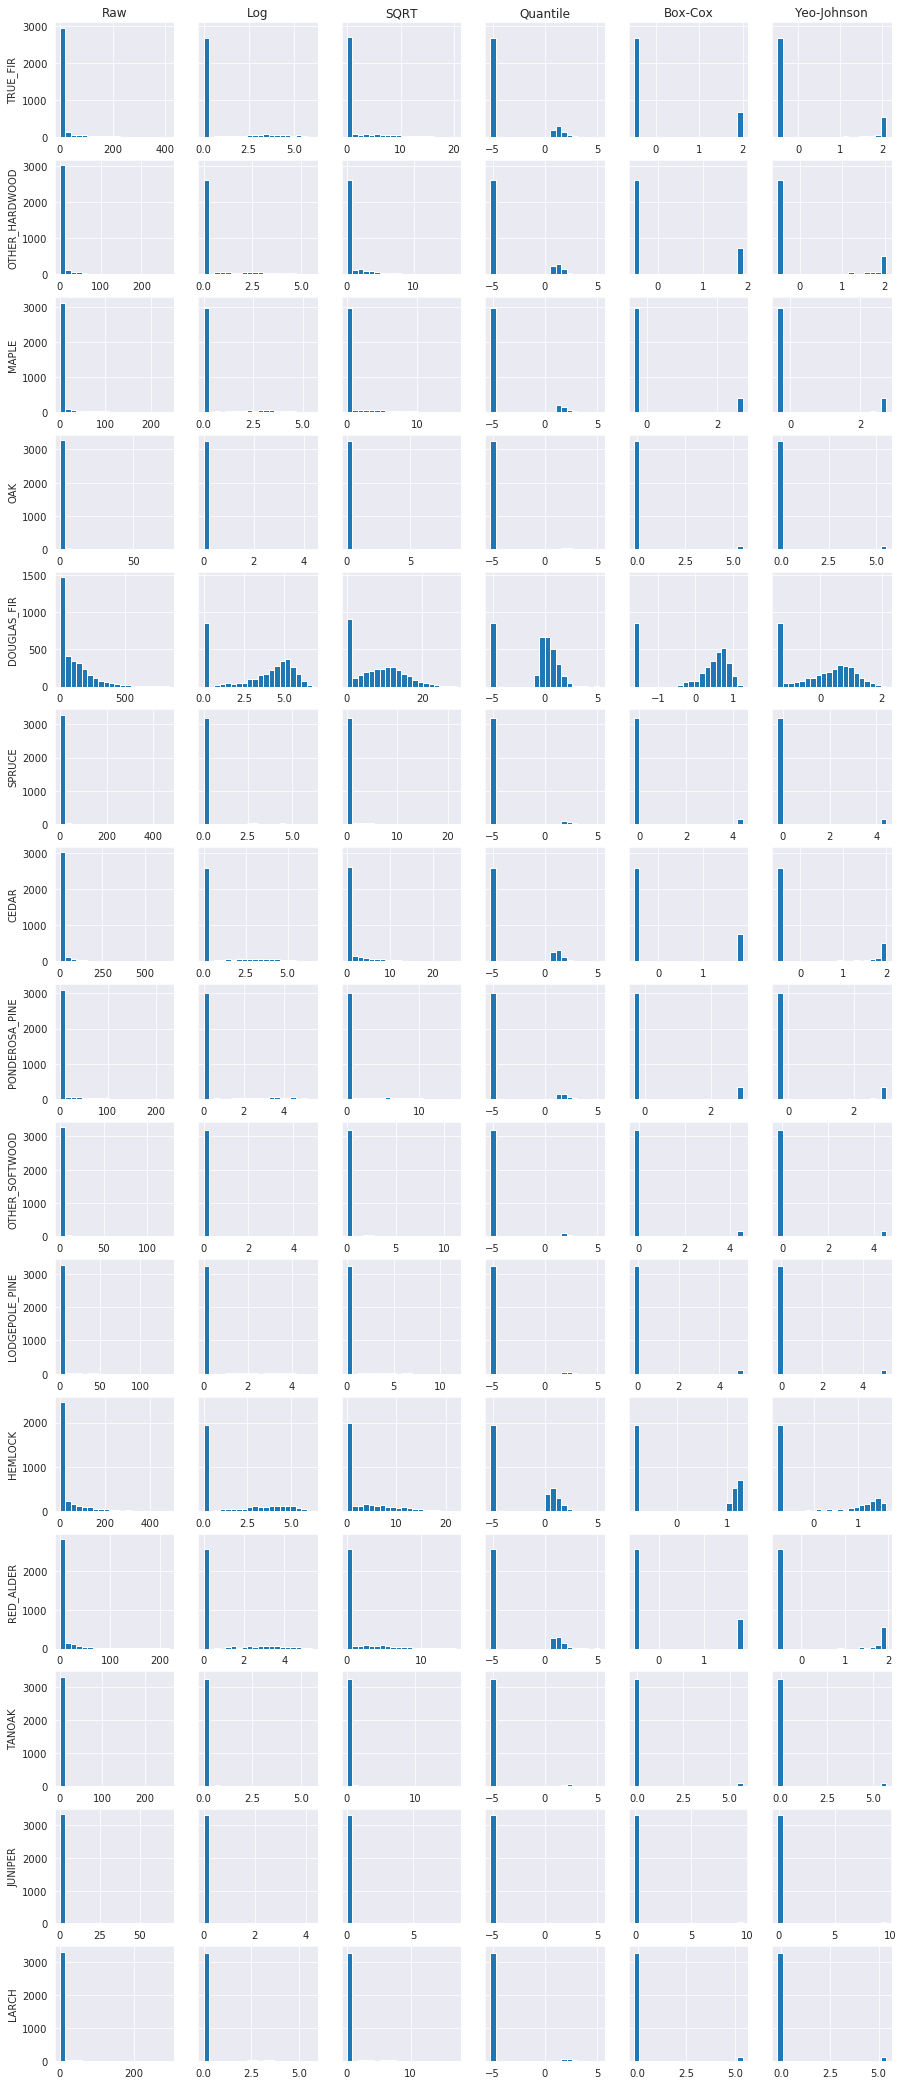

In [15]:
fig, axs = plt.subplots(len(Y_COLS),6, figsize=(15,2.5*len(Y_COLS)), sharey='row')

qtrans = QuantileTransformer(output_distribution='normal', random_state=127)
box_cox = PowerTransformer(method='box-cox')
yeo_johnson = PowerTransformer(method='yeo-johnson')

VALS = [y_train.values,
        np.log1p(y_train.values),
        np.sqrt(y_train.values),
        qtrans.fit_transform(y_train.values),
        box_cox.fit_transform(y_train.values + 1e-9),
        yeo_johnson.fit_transform(y_train.values)]

TITLES = ['Raw', 'Log', 'SQRT', 'Quantile', 'Box-Cox', 'Yeo-Johnson']
SHAPIRO_ps = [shapiro(vals)[-1] for vals in VALS]

for j, vals in enumerate(VALS):
    axs[0,j].set_title(TITLES[j])
    for i, spp in enumerate(Y_COLS):
        axs[i,j].hist(vals[:,i], bins=20)
        axs[i,0].set_ylabel(Y_COLS[i])
    
plt.show();

In [16]:
# choose your transformer here
transformer = FunctionTransformer() # no transformation

In [17]:
transformer.fit(df[Y_COLS])
y_train.loc[:,Y_COLS], y_test.loc[:,Y_COLS] = transformer.transform(y_train), transformer.transform(y_test)

/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

## Split datasets by ecoregion
We want to explore model transferability between regions, so we'll train models independently on subsets of the data within a single ecoregion, as well as a model that is trained on all available ecoregions. 

In [18]:
ecoregions = [reg for reg in pd.unique(df.ecoregion3) if ecoreg_counts.loc[reg]['uuid'] > 20]

eco_train_idx = [x_train.loc[x_train.ecoregion3 == eco].index.values for eco in ecoregions]
eco_test_idx = [x_test.loc[x_test.ecoregion3 == eco].index.values for eco in ecoregions]

eco_xtrain_dfs = [x_train.loc[x_train.ecoregion3 == eco].drop(['ecoregion3'], axis=1) for eco in ecoregions]
eco_ytrain_dfs = [y_train.loc[idx] for idx in eco_train_idx]
eco_xtest_dfs = [x_test.loc[x_test.ecoregion3 == eco].drop(['ecoregion3'], axis=1) for eco in ecoregions]
eco_ytest_dfs = [y_test.loc[idx] for idx in eco_test_idx]

# append a "global" model that contains data from all ecoregions
ecoregions.append('all')
ecoregion_names = ['_'.join(x.split('_')[0:2]) for x in ecoregions]
eco_xtrain_dfs.append(x_train.drop(['ecoregion3'], axis=1))
eco_ytrain_dfs.append(y_train)
eco_xtest_dfs.append(x_test.drop(['ecoregion3'], axis=1))
eco_ytest_dfs.append(y_test)

## Scoring
We'll use Root Mean Square Error to evaluate model performance.

In [19]:
def rmse(pred, obs):
    # use our transformer to calculate RMSE on the original data scale
    pred = transformer.inverse_transform(pred.reshape(-1,1)).ravel()
    obs = transformer.inverse_transform(obs.reshape(-1,1)).ravel()
    
    return np.sqrt((np.square(obs-pred)).mean())

In [20]:
def nrmse(pred, obs):
    # use our transformer to calculate percent RMSE on the original data scale
    this_rmse = rmse(pred,obs)
    obs = transformer.inverse_transform(obs.reshape(-1,1)).ravel()
    
    return this_rmse/obs.mean()

In [21]:
def mae(pred, obs):
    # use our transformer to calculate mean absolute error on the original data scale
    pred = transformer.inverse_transform(pred.reshape(-1,1)).ravel()
    obs = transformer.inverse_transform(obs.reshape(-1,1)).ravel()
    
    return abs(pred - obs).mean()

In [22]:
def mape(pred, obs):
    # use our transformer to calculate mean average percent error on the original data scale
    pred = transformer.inverse_transform(pred.reshape(-1,1)).ravel()
    obs = transformer.inverse_transform(obs.reshape(-1,1)).ravel()
    
    return abs(pred - obs).mean() / obs.mean()

In [23]:
def bias(pred, obs):
    # use our transformer to calculate mean bias on the original data scale
    pred = transformer.inverse_transform(pred.reshape(-1,1)).ravel()
    obs = transformer.inverse_transform(obs.reshape(-1,1)).ravel()
    
    return (pred - obs).mean()

This helper function will calculate RMSE scores for each regionally-trained model and the global model on each ecoregion.

In [24]:
def get_score_df(models, metric=rmse, feature_selectors=None, weighted=False):
    regional_scores = []
    global_scores = []
    counts = []
    
    for i, mod in enumerate(models):
        X_idx = eco_xtest_dfs[i].index
        if weighted:
            weights = df.reindex(X_idx)['weight']
        else:
            weights = np.ones(X_idx.shape)
        X_test = x_scaler.transform(eco_xtest_dfs[i])
        if feature_selectors:
            X_test = feature_selectors[i].transform(X_test)
        y_test = eco_ytest_dfs[i]
        reg_score = metric(mod.predict(X_test), y_test, weights)
        regional_scores.append(reg_score.round(3))
        
        if feature_selectors:
            X_test = x_scaler.transform(eco_xtest_dfs[i])
            X_test = feature_selectors[-1].transform(X_test)
        glob_score = metric(models[-1].predict(X_test), y_test, weights)
        global_scores.append(glob_score.round(3))
        count = len(eco_xtrain_dfs[i] + eco_xtest_dfs[i])
        counts.append(count)
        
    data = list(zip(regional_scores, global_scores, counts))
    res_df = pd.DataFrame(data=data,
                          columns=['regional_model', 'global_model', 'n'],
                          index=ecoregion_names)
    
    return res_df

In [175]:
all_abund = ((df[Y_COLS] / (df[Y_COLS].sum(axis=1).values.reshape(-1,1) + 1e-9) > 0.33)*1)
all_abund.sum()

TRUE_FIR           308
OTHER_HARDWOOD     165
MAPLE               57
OAK                 14
DOUGLAS_FIR       2550
SPRUCE              60
CEDAR              199
PONDEROSA_PINE     276
OTHER_SOFTWOOD      14
LODGEPOLE_PINE      63
HEMLOCK            683
RED_ALDER          287
TANOAK              36
JUNIPER             25
LARCH               42
dtype: int64

In [176]:
train_abund = ((train[Y_COLS] / (train[Y_COLS].sum(axis=1).values.reshape(-1,1) + 1e-9) > 0.33)*1)
train_abund.sum()

TRUE_FIR           249
OTHER_HARDWOOD     127
MAPLE               46
OAK                 13
DOUGLAS_FIR       2041
SPRUCE              48
CEDAR              157
PONDEROSA_PINE     222
OTHER_SOFTWOOD      11
LODGEPOLE_PINE      50
HEMLOCK            537
RED_ALDER          223
TANOAK              30
JUNIPER             19
LARCH               33
dtype: int64

In [177]:
test_abund = ((test[Y_COLS] / (test[Y_COLS].sum(axis=1).values.reshape(-1,1) + 1e-9) > 0.33)*1)
test_abund.sum()

TRUE_FIR           59
OTHER_HARDWOOD     38
MAPLE              11
OAK                 1
DOUGLAS_FIR       509
SPRUCE             12
CEDAR              42
PONDEROSA_PINE     54
OTHER_SOFTWOOD      3
LODGEPOLE_PINE     13
HEMLOCK           146
RED_ALDER          64
TANOAK              6
JUNIPER             6
LARCH               9
dtype: int64

In [197]:
df.loc[test_abund[test_abund.MAPLE == 1].index]

,uuid,lidar_year,lat,lon,orig_id,source,meas_yr,ecoregion3,plot_size_ac,num_returns,...,JUNIPER,LARCH,fvs_year,year_diff,returns_per_m2,agency_BLM,agency_USFS,agency_WADNR,forest_type_id,weight
2983,968110a7-f065-4be8-835b-65d8b25ea5a5,2008,43.259989,-123.793118,63-20,BLM-COOS,2011,coast_range,0.125,3871,...,0.0,0.0,2011.0,3,7.652353,1,0,0,41,0.045455
4507,e19289f9-3641-41fb-a300-b043f9ee3173,2008,43.839489,-123.817351,33-22,BLM-COOS,2011,coast_range,0.125,6215,...,0.0,0.0,2011.0,3,12.286069,1,0,0,42,0.100000
1680,54f8748a-855a-42f1-b3f5-795ac16e1b2e,2008,43.069318,-123.931287,33-11,BLM-COOS,2011,coast_range,0.125,5691,...,0.0,0.0,2011.0,3,11.250204,1,0,0,45,0.058824
3483,aedc9b98-34a1-4891-9ec1-3b57dc294480,2008,43.232729,-123.927476,32-16,BLM-COOS,2010,coast_range,0.125,10315,...,0.0,0.0,2010.0,2,20.391118,1,0,0,44,0.333333
813,2b9fe89e-1939-4b6b-915c-af8b53f1f4fb,2008,42.989261,-123.861122,43-21,BLM-COOS,2011,coast_range,0.125,3632,...,0.0,0.0,2011.0,3,7.179888,1,0,0,41,0.045455
1342,4388ac5b-9d07-4f09-89aa-363351056df7,2008,43.168823,-123.929961,52-02,BLM-COOS,2010,coast_range,0.125,7902,...,0.0,0.0,2010.0,2,15.621000,1,0,0,41,0.045455
4057,cd451ab1-ec12-446b-ad40-c5bf6d603adf,2008,43.220276,-123.916805,73-16,BLM-COOS,2010,coast_range,0.125,4060,...,0.0,0.0,2010.0,2,8.025976,1,0,0,43,0.333333
3253,a5f1c428-d09c-4d57-98db-dde995bd5435,2008,43.229599,-123.987247,42-A02,BLM-COOS,2010,coast_range,0.125,3749,...,0.0,0.0,2010.0,2,7.411178,1,0,0,42,0.100000
1712,565c2b03-b7b0-4d88-89b3-e27be5a85ea9,2008,43.118403,-123.920938,32-15,BLM-COOS,2011,coast_range,0.125,3254,...,0.0,0.0,2011.0,3,6.432642,1,0,0,45,0.058824
1748,584e91e4-6ce7-44e7-b9ce-d57e173eb329,2008,43.099263,-124.006368,63-05,BLM-COOS,2011,coast_range,0.125,4129,...,0.0,0.0,2011.0,3,8.162378,1,0,0,41,0.045455


## Fit some models
For each type of model, we'll employ cross-validation to tune model hyperparameters, generating a tuned model for each ecoregion as well as a tuned model using all training data. We'll work our way through:

#### ElasticNet Regression
Linear model that employs a mix of L1 and L2 regularization to penalize model complexity

#### LASSO Regression  
Linear model that employs L1 regularization to penalize model complexity. We'll also work with a feature-selection process to fit models capped to an explicitly-predefined number of features.

#### K-Nearest Neighbor Regression

#### Random Forest Regression

#### Gradient Boosting Trees Regression

#### Support Vector Machine Regression

## K-Nearest Neighbors Regression

In [25]:
from sklearn.metrics import make_scorer

In [36]:
def mean_braycurtis(x,y,weights=None):
    dist = (abs(x - y)).sum(axis=1) / (abs(x + y)).sum(axis=1)
    if weights is None:
        weights = np.ones(dist.shape)
    return (dist*weights).mean()

def bray_curtis(x,y):
    return (abs(x - y)).sum(axis=1) / (abs(x + y)).sum(axis=1)

def mean_manhattan(x,y):
    dist = (abs(x - y)).sum(axis=1)
    return dist.mean()

def one_manhattan(x,y):
    return (abs(x - y)).sum(axis=1)

def mean_total_diff(x,y):
    diff = x.sum(axis=1) - y.sum(axis=1)
    return diff.mean()

braycurtis = make_scorer(mean_braycurtis, greater_is_better=False)
manhattan = make_scorer(mean_manhattan, greater_is_better=False)

In [42]:
def mean_missed_abund_spp(x,y,weights=None):
    """
    Calculates abundant elements (species groups) in x and y with a threshold of 
    33% to indicate abundance, compares x and y to identify number of mis-classified
    elements, then calculates average if x and y have multiple rows.
    
    This represents the average number of abundant species groups missed (via omission
    or comission) in predictions versus observations.
    """
    x = np.atleast_2d(x)
    y = np.atleast_2d(y)
    
    if weights is None:
        weights=np.ones(y.shape)
    
    # to avoid divide-by-zero warnings, add 1e-9 to total basal area
    x_baprop = x / (x.sum(axis=1).reshape(-1,1) + 1e-9)
    x_baprop = (x_baprop)
    x_abundant = (x_baprop > 0.33) * 1
    
    y_baprop = y / (y.sum(axis=1).reshape(-1,1) + 1e-9)
    y_abundant = (y_baprop > 0.33) * 1
    
    return (abs(x_abundant - y_abundant).sum(axis=1) * weights).mean()

In [43]:
def missed_abund_spp(x,y):
    """
    Calculates abundant elements (species groups) in x and y with a threshold of 
    33% to indicate abundance, compares x and y to identify number of mis-classified
    elements.
    """
    x = np.atleast_2d(x)
    y = np.atleast_2d(y)
    
    # to avoid divide-by-zero warnings, add 1e-9 to total basal area
    x_baprop = x / (x.sum(axis=1).reshape(-1,1) + 1e-9)
    x_baprop = (x_baprop)
    x_abundant = (x_baprop > 0.33) * 1
    
    y_baprop = y / (y.sum(axis=1).reshape(-1,1) + 1e-9)
    y_abundant = (y_baprop > 0.33) * 1
    
    return (abs(x_abundant - y_abundant).sum(axis=1))

In [195]:
def confuse_abund_spp(x,y):
    """
    Counts commission and omission errors for each species group in x and y using a threshold of 
    33% to indicate abundance.
    
    If x contains predictions and y contains observations:
    Values of '11' indicate correctly predicted presence, true positive. 
    Values of '00' indicate correctly predicted absence, true negative.
    Values of '10' indicate incorrectly predicted presence, false positive. 
    Values of '01' indicate incorrectly predicted absence, false negative.
    
    Returns an array that is the same shape as x and y.
    """
    x = np.atleast_2d(x)
    y = np.atleast_2d(y)
    
    # to avoid divide-by-zero warnings, add 1e-9 to total basal area
    x_baprop = x / (x.sum(axis=1).reshape(-1,1) + 1e-9)
    x_baprop = (x_baprop)
    x_abundant = (x_baprop > 0.33) * 1
    
    y_baprop = y / (y.sum(axis=1).reshape(-1,1) + 1e-9)
    y_abundant = (y_baprop > 0.33) * 1
    
    return np.core.defchararray.add(x_abundant.astype(str), y_abundant.astype(str)) 

## K-Nearest Neighbors Regression

In [37]:
# Set the parameters by cross-validation
knn_params = {'n_neighbors': [1,2,3,4,5,10,20],
              'weights': ['uniform', 'distance'],
              'metric': ['minkowski', 'manhattan']}


knn_gs = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=knn_params, 
                     cv=3, n_jobs=-1, verbose=2, scoring=braycurtis)

best_knns = []
for i in range(len(ecoregions)):
    X = x_scaler.transform(eco_xtrain_dfs[i])
    y = eco_ytrain_dfs[i]
    knn_gs.fit(X, y)
    best_fit = knn_gs.best_estimator_
    # refit to the entire dataset, not just the CV folds
    best_fit.fit(X, y)
    best_knns.append(best_fit)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 out of  84 | elapsed:    3.0s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    3.1s finished
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Done  21 out of  84 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  64 out of  84 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  84 | elapsed:    0.1s remaining:    0.3s


Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  84 | elapsed:    0.1s remaining:    0.3s


Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Done  64 out of  84 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Done  21 out of  84 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  64 out of  84 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  84 | elapsed:    0.1s remaining:    0.3s


Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  84 | elapsed:    0.1s remaining:    0.3s


Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Done  64 out of  84 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    0.3s finished
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  84 | elapsed:    0.1s remaining:    0.3s


Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Done  64 out of  84 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    0.3s finished
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  84 | elapsed:    0.1s remaining:    0.3s


Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Done  64 out of  84 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    0.3s finished
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Done  64 out of  84 | elapsed:    1.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    2.2s finished


In [44]:
knn_res = get_score_df(best_knns, mean_missed_abund_spp, weighted=True)
knn_res

,regional_model,global_model,n
blue_mountains,0.168,0.158,108
coast_range,0.016,0.016,1809
eastern_cascades,0.073,0.077,409
north_cascades,0.014,0.018,505
cascades,0.019,0.026,747
klamath_mountains,0.068,0.070,323
northern_rockies,0.068,0.062,103
puget_lowland,0.063,0.061,149
willamette_valley,0.000,0.000,43
all,0.035,0.035,4210


In [45]:
knn_res = get_score_df(best_knns, mean_missed_abund_spp, weighted=False)
knn_res

,regional_model,global_model,n
blue_mountains,1.040,0.960,108
coast_range,0.543,0.549,1809
eastern_cascades,0.988,0.976,409
north_cascades,0.865,0.901,505
cascades,0.736,0.767,747
klamath_mountains,0.556,0.571,323
northern_rockies,1.370,1.148,103
puget_lowland,1.033,0.933,149
willamette_valley,0.000,0.000,43
all,0.723,0.723,4210


In [46]:
knn_res = get_score_df(best_knns, mean_braycurtis, weighted=True)
knn_res

,regional_model,global_model,n
blue_mountains,0.042,0.042,108
coast_range,0.005,0.005,1809
eastern_cascades,0.023,0.022,409
north_cascades,0.006,0.006,505
cascades,0.007,0.007,747
klamath_mountains,0.019,0.021,323
northern_rockies,0.018,0.020,103
puget_lowland,0.021,0.021,149
willamette_valley,0.000,0.000,43
all,0.011,0.011,4210


In [47]:
knn_res = get_score_df(best_knns, mean_braycurtis, weighted=False)
knn_res

,regional_model,global_model,n
blue_mountains,0.488,0.489,108
coast_range,0.381,0.378,1809
eastern_cascades,0.512,0.503,409
north_cascades,0.465,0.476,505
cascades,0.426,0.431,747
klamath_mountains,0.412,0.437,323
northern_rockies,0.688,0.632,103
puget_lowland,0.526,0.472,149
willamette_valley,0.240,0.167,43
all,0.432,0.432,4210


(array([453.,   0., 217.,   0.,   0., 146.,   0.,  34.,   0.,   1.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

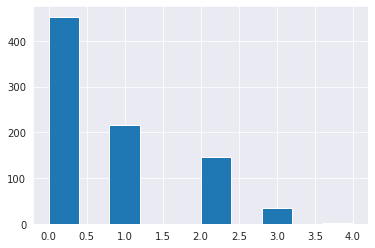

In [48]:
preds = best_knns[-1].predict(x_scaler.transform(eco_xtest_dfs[-1]))
obs = eco_ytest_dfs[-1]
missed_full = missed_abund_spp(preds, obs)
plt.hist(missed_full.astype(int))

In [196]:
for i, region in enumerate(ecoregions[:-1]):
    preds = best_knns[i].predict(x_scaler.transform(eco_xtest_dfs[i]))
    obs = eco_ytest_dfs[i]
    confusion = confuse_abund_spp(preds, obs)

    confusion_df = pd.DataFrame(confusion, columns=Y_COLS, index=eco_xtest_dfs[i].index)
    confusion_types = ['true_positive', 'true_negative', 'false_positive', 'false_negative', 'total']
    confusion_results = []
    for col in Y_COLS:
        true_positive = len(confusion_df.loc[confusion_df[col] == '11'])
        true_negative = len(confusion_df.loc[confusion_df[col] == '00'])
        false_positive = len(confusion_df.loc[confusion_df[col] == '10'])
        false_negative = len(confusion_df.loc[confusion_df[col] == '01'])
        total = len(confusion_df)
        confusion_results.append(pd.Series([true_positive, true_negative, false_positive, false_negative, total], name=col, index=confusion_types))    

    confusion_matrix = pd.concat(confusion_results, axis=1)
    

    accuracy = (confusion_matrix.loc[['true_positive', 'true_negative']].sum() / confusion_matrix.loc[['total']].sum()).to_frame().T.rename({0: 'accuracy'})
    sensitivity = confusion_matrix.loc[['true_positive']] / confusion_matrix.loc[['true_positive', 'false_negative']].sum()
    specificity = confusion_matrix.loc[['true_negative']] / confusion_matrix.loc[['true_negative', 'false_positive']].sum()
    precision = (confusion_matrix.loc[['true_positive']] / confusion_matrix.loc[['true_positive', 'false_positive']].sum()).rename({'true_positive': 'precision'})

    sensitivity = sensitivity.rename({'true_positive': 'sensitivity'})
    specificity = specificity.rename({'true_negative': 'specificity'})
    true_skill = pd.Series((sensitivity.values + specificity.values - 1).ravel(), name='true_skill', index=Y_COLS).to_frame().T

    print('\nRegional Model', region.upper(), '\n')
    display(confusion_matrix)
    display(pd.concat([accuracy, sensitivity, specificity, precision, true_skill])
     .style
     .format('{:.0%}'))


Regional Model BLUE_MOUNTAINS 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,4,0,0,0,1,0,0,10,0,0,0,0,0,3,0
true_negative,15,23,25,25,21,25,25,8,25,22,25,25,25,18,24
false_positive,3,2,0,0,1,0,0,4,0,2,0,0,0,1,0
false_negative,3,0,0,0,2,0,0,3,0,1,0,0,0,3,1
total,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,76%,92%,100%,100%,88%,100%,100%,72%,100%,88%,100%,100%,100%,84%,96%
sensitivity,57%,nan%,nan%,nan%,33%,nan%,nan%,77%,nan%,0%,nan%,nan%,nan%,50%,0%
specificity,83%,92%,100%,100%,95%,100%,100%,67%,100%,92%,100%,100%,100%,95%,100%
precision,57%,0%,nan%,nan%,50%,nan%,nan%,71%,nan%,0%,nan%,nan%,nan%,75%,nan%
true_skill,40%,nan%,nan%,nan%,29%,nan%,nan%,44%,nan%,-8%,nan%,nan%,nan%,45%,0%



Regional Model COAST_RANGE 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,0,0,0,0,240,0,2,0,0,0,39,12,0,0,0
true_negative,344,337,337,347,43,344,330,348,348,348,254,314,348,348,348
false_positive,0,1,0,0,53,0,1,0,0,0,26,4,0,0,0
false_negative,4,10,11,1,12,4,15,0,0,0,29,18,0,0,0
total,348,348,348,348,348,348,348,348,348,348,348,348,348,348,348


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,99%,97%,97%,100%,81%,99%,95%,100%,100%,100%,84%,94%,100%,100%,100%
sensitivity,0%,0%,0%,0%,95%,0%,12%,nan%,nan%,nan%,57%,40%,nan%,nan%,nan%
specificity,100%,100%,100%,100%,45%,100%,100%,100%,100%,100%,91%,99%,100%,100%,100%
precision,nan%,0%,nan%,nan%,82%,nan%,67%,nan%,nan%,nan%,60%,75%,nan%,nan%,nan%
true_skill,0%,-0%,0%,0%,40%,0%,11%,nan%,nan%,nan%,48%,39%,nan%,nan%,nan%



Regional Model EASTERN_CASCADES_SLOPES_AND_FOOTHILLS 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,9,4,0,0,21,0,0,24,0,0,0,0,0,0,0
true_negative,56,79,84,84,42,80,84,37,83,77,82,83,84,84,80
false_positive,9,0,0,0,11,0,0,22,0,1,0,0,0,0,0
false_negative,10,1,0,0,10,4,0,1,1,6,2,1,0,0,4
total,84,84,84,84,84,84,84,84,84,84,84,84,84,84,84


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,77%,99%,100%,100%,75%,95%,100%,73%,99%,92%,98%,99%,100%,100%,95%
sensitivity,47%,80%,nan%,nan%,68%,0%,nan%,96%,0%,0%,0%,0%,nan%,nan%,0%
specificity,86%,100%,100%,100%,79%,100%,100%,63%,100%,99%,100%,100%,100%,100%,100%
precision,50%,100%,nan%,nan%,66%,nan%,nan%,52%,nan%,0%,nan%,nan%,nan%,nan%,nan%
true_skill,34%,80%,nan%,nan%,47%,0%,nan%,59%,0%,-1%,0%,0%,nan%,nan%,0%



Regional Model NORTH_CASCADES 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,1,0,0,0,36,2,0,8,0,0,30,0,0,0,0
true_negative,102,108,111,111,44,106,105,97,111,108,60,99,111,111,108
false_positive,2,1,0,0,26,1,0,5,0,0,13,0,0,0,1
false_negative,6,2,0,0,5,2,6,1,0,3,8,12,0,0,2
total,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,93%,97%,100%,100%,72%,97%,95%,95%,100%,97%,81%,89%,100%,100%,97%
sensitivity,14%,0%,nan%,nan%,88%,50%,0%,89%,nan%,0%,79%,0%,nan%,nan%,0%
specificity,98%,99%,100%,100%,63%,99%,100%,95%,100%,100%,82%,100%,100%,100%,99%
precision,33%,0%,nan%,nan%,58%,67%,nan%,62%,nan%,nan%,70%,nan%,nan%,nan%,0%
true_skill,12%,-1%,nan%,nan%,51%,49%,0%,84%,nan%,0%,61%,0%,nan%,nan%,-1%



Regional Model CASCADES 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,15,0,0,0,87,0,1,0,0,0,9,7,0,0,0
true_negative,129,155,159,159,27,159,149,157,159,157,123,139,159,159,159
false_positive,11,0,0,0,34,0,3,0,0,0,6,3,0,0,0
false_negative,4,4,0,0,11,0,6,2,0,2,21,10,0,0,0
total,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,91%,97%,100%,100%,72%,100%,94%,99%,100%,99%,83%,92%,100%,100%,100%
sensitivity,79%,0%,nan%,nan%,89%,nan%,14%,0%,nan%,0%,30%,41%,nan%,nan%,nan%
specificity,92%,100%,100%,100%,44%,100%,98%,100%,100%,100%,95%,98%,100%,100%,100%
precision,58%,nan%,nan%,nan%,72%,nan%,25%,nan%,nan%,nan%,60%,70%,nan%,nan%,nan%
true_skill,71%,0%,nan%,nan%,33%,nan%,12%,0%,nan%,0%,25%,39%,nan%,nan%,nan%



Regional Model KLAMATH_MOUNTAINS_CALIFORNIA_HIGH_NORTH_COAST_RANGE 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,0,1,0,0,50,0,0,0,0,0,0,0,4,0,0
true_negative,62,51,63,63,2,63,60,63,61,63,62,63,53,63,63
false_positive,0,2,0,0,10,0,0,0,0,0,0,0,4,0,0
false_negative,1,9,0,0,1,0,3,0,2,0,1,0,2,0,0
total,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,98%,83%,100%,100%,83%,100%,95%,100%,97%,100%,98%,100%,90%,100%,100%
sensitivity,0%,10%,nan%,nan%,98%,nan%,0%,nan%,0%,nan%,0%,nan%,67%,nan%,nan%
specificity,100%,96%,100%,100%,17%,100%,100%,100%,100%,100%,100%,100%,93%,100%,100%
precision,nan%,33%,nan%,nan%,83%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,50%,nan%,nan%
true_skill,0%,6%,nan%,nan%,15%,nan%,0%,nan%,0%,nan%,0%,nan%,60%,nan%,nan%



Regional Model NORTHERN_ROCKIES 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,0,0,0,0,8,0,1,3,0,0,0,0,0,0,0
true_negative,23,25,27,27,9,27,21,17,24,27,26,27,27,27,22
false_positive,2,0,0,0,7,0,2,5,3,0,0,0,0,0,3
false_negative,2,2,0,0,3,0,3,2,0,0,1,0,0,0,2
total,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,85%,93%,100%,100%,63%,100%,81%,74%,89%,100%,96%,100%,100%,100%,81%
sensitivity,0%,0%,nan%,nan%,73%,nan%,25%,60%,nan%,nan%,0%,nan%,nan%,nan%,0%
specificity,92%,100%,100%,100%,56%,100%,91%,77%,89%,100%,100%,100%,100%,100%,88%
precision,0%,nan%,nan%,nan%,53%,nan%,33%,38%,0%,nan%,nan%,nan%,nan%,nan%,0%
true_skill,-8%,0%,nan%,nan%,29%,nan%,16%,37%,nan%,nan%,0%,nan%,nan%,nan%,-12%



Regional Model PUGET_LOWLAND 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0
true_negative,30,25,30,30,1,30,25,30,30,29,24,26,30,30,30
false_positive,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0
false_negative,0,5,0,0,0,0,5,0,0,1,6,4,0,0,0
total,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,100%,83%,100%,100%,67%,100%,83%,100%,100%,97%,80%,87%,100%,100%,100%
sensitivity,nan%,0%,nan%,nan%,100%,nan%,0%,nan%,nan%,0%,0%,0%,nan%,nan%,nan%
specificity,100%,100%,100%,100%,9%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%
precision,nan%,nan%,nan%,nan%,66%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%
true_skill,nan%,0%,nan%,nan%,9%,nan%,0%,nan%,nan%,0%,0%,0%,nan%,nan%,nan%



Regional Model WILLAMETTE_VALLEY 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0
true_negative,3,3,3,3,0,3,3,3,3,3,3,3,3,3,3
false_positive,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
false_negative,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
total,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%
sensitivity,nan%,nan%,nan%,nan%,100%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%
specificity,100%,100%,100%,100%,nan%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%
precision,nan%,nan%,nan%,nan%,100%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%
true_skill,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%


In [198]:
for i, region in enumerate(ecoregions):
    preds = best_knns[-1].predict(x_scaler.transform(eco_xtest_dfs[i]))
    obs = eco_ytest_dfs[i]
    confusion = confuse_abund_spp(preds, obs)

    confusion_df = pd.DataFrame(confusion, columns=Y_COLS, index=eco_xtest_dfs[i].index)
    confusion_types = ['true_positive', 'true_negative', 'false_positive', 'false_negative', 'total']
    confusion_results = []
    for col in Y_COLS:
        true_positive = len(confusion_df.loc[confusion_df[col] == '11'])
        true_negative = len(confusion_df.loc[confusion_df[col] == '00'])
        false_positive = len(confusion_df.loc[confusion_df[col] == '10'])
        false_negative = len(confusion_df.loc[confusion_df[col] == '01'])
        total = len(confusion_df)
        confusion_results.append(pd.Series([true_positive, true_negative, false_positive, false_negative, total], name=col, index=confusion_types))    

    confusion_matrix = pd.concat(confusion_results, axis=1)
    

    accuracy = (confusion_matrix.loc[['true_positive', 'true_negative']].sum() / confusion_matrix.loc[['total']].sum()).to_frame().T.rename({0: 'accuracy'})
    sensitivity = confusion_matrix.loc[['true_positive']] / confusion_matrix.loc[['true_positive', 'false_negative']].sum()
    specificity = confusion_matrix.loc[['true_negative']] / confusion_matrix.loc[['true_negative', 'false_positive']].sum()
    precision = (confusion_matrix.loc[['true_positive']] / confusion_matrix.loc[['true_positive', 'false_positive']].sum()).rename({'true_positive': 'precision'})

    sensitivity = sensitivity.rename({'true_positive': 'sensitivity'})
    specificity = specificity.rename({'true_negative': 'specificity'})
    true_skill = pd.Series((sensitivity.values + specificity.values - 1).ravel(), name='true_skill', index=Y_COLS).to_frame().T

    print('\nGlobal Model', region.upper(), '\n')
    display(confusion_matrix)
    display(pd.concat([accuracy, sensitivity, specificity, precision, true_skill])
     .style
     .format('{:.0%}'))


Global Model BLUE_MOUNTAINS 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,2,0,0,0,0,0,0,11,0,1,0,0,0,3,0
true_negative,17,25,25,25,22,25,25,5,25,23,25,25,25,18,24
false_positive,1,0,0,0,0,0,0,7,0,1,0,0,0,1,0
false_negative,5,0,0,0,3,0,0,2,0,0,0,0,0,3,1
total,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,76%,100%,100%,100%,88%,100%,100%,64%,100%,96%,100%,100%,100%,84%,96%
sensitivity,29%,nan%,nan%,nan%,0%,nan%,nan%,85%,nan%,100%,nan%,nan%,nan%,50%,0%
specificity,94%,100%,100%,100%,100%,100%,100%,42%,100%,96%,100%,100%,100%,95%,100%
precision,67%,nan%,nan%,nan%,nan%,nan%,nan%,61%,nan%,50%,nan%,nan%,nan%,75%,nan%
true_skill,23%,nan%,nan%,nan%,0%,nan%,nan%,26%,nan%,96%,nan%,nan%,nan%,45%,0%



Global Model COAST_RANGE 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,0,0,0,0,242,0,2,0,0,0,38,12,0,0,0
true_negative,344,337,337,347,42,344,328,348,348,348,254,314,348,348,348
false_positive,0,1,0,0,54,0,3,0,0,0,26,4,0,0,0
false_negative,4,10,11,1,10,4,15,0,0,0,30,18,0,0,0
total,348,348,348,348,348,348,348,348,348,348,348,348,348,348,348


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,99%,97%,97%,100%,82%,99%,95%,100%,100%,100%,84%,94%,100%,100%,100%
sensitivity,0%,0%,0%,0%,96%,0%,12%,nan%,nan%,nan%,56%,40%,nan%,nan%,nan%
specificity,100%,100%,100%,100%,44%,100%,99%,100%,100%,100%,91%,99%,100%,100%,100%
precision,nan%,0%,nan%,nan%,82%,nan%,40%,nan%,nan%,nan%,59%,75%,nan%,nan%,nan%
true_skill,0%,-0%,0%,0%,40%,0%,11%,nan%,nan%,nan%,47%,39%,nan%,nan%,nan%



Global Model EASTERN_CASCADES_SLOPES_AND_FOOTHILLS 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,9,4,0,0,21,0,0,24,0,0,0,0,0,0,0
true_negative,55,79,84,84,40,80,84,41,83,77,82,83,84,84,80
false_positive,10,0,0,0,13,0,0,18,0,1,0,0,0,0,0
false_negative,10,1,0,0,10,4,0,1,1,6,2,1,0,0,4
total,84,84,84,84,84,84,84,84,84,84,84,84,84,84,84


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,76%,99%,100%,100%,73%,95%,100%,77%,99%,92%,98%,99%,100%,100%,95%
sensitivity,47%,80%,nan%,nan%,68%,0%,nan%,96%,0%,0%,0%,0%,nan%,nan%,0%
specificity,85%,100%,100%,100%,75%,100%,100%,69%,100%,99%,100%,100%,100%,100%,100%
precision,47%,100%,nan%,nan%,62%,nan%,nan%,57%,nan%,0%,nan%,nan%,nan%,nan%,nan%
true_skill,32%,80%,nan%,nan%,43%,0%,nan%,65%,0%,-1%,0%,0%,nan%,nan%,0%



Global Model NORTH_CASCADES 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,4,0,0,0,36,1,0,6,0,0,25,0,0,0,0
true_negative,102,109,111,111,41,105,105,98,111,108,62,99,111,111,109
false_positive,2,0,0,0,29,2,0,4,0,0,11,0,0,0,0
false_negative,3,2,0,0,5,3,6,3,0,3,13,12,0,0,2
total,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,95%,98%,100%,100%,69%,95%,95%,94%,100%,97%,78%,89%,100%,100%,98%
sensitivity,57%,0%,nan%,nan%,88%,25%,0%,67%,nan%,0%,66%,0%,nan%,nan%,0%
specificity,98%,100%,100%,100%,59%,98%,100%,96%,100%,100%,85%,100%,100%,100%,100%
precision,67%,nan%,nan%,nan%,55%,33%,nan%,60%,nan%,nan%,69%,nan%,nan%,nan%,nan%
true_skill,55%,0%,nan%,nan%,46%,23%,0%,63%,nan%,0%,51%,0%,nan%,nan%,0%



Global Model CASCADES 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,15,0,0,0,88,0,0,0,0,0,6,5,0,0,0
true_negative,128,155,159,159,25,159,152,156,159,157,124,139,159,159,159
false_positive,12,0,0,0,36,0,0,1,0,0,5,3,0,0,0
false_negative,4,4,0,0,10,0,7,2,0,2,24,12,0,0,0
total,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,90%,97%,100%,100%,71%,100%,96%,98%,100%,99%,82%,91%,100%,100%,100%
sensitivity,79%,0%,nan%,nan%,90%,nan%,0%,0%,nan%,0%,20%,29%,nan%,nan%,nan%
specificity,91%,100%,100%,100%,41%,100%,100%,99%,100%,100%,96%,98%,100%,100%,100%
precision,56%,nan%,nan%,nan%,71%,nan%,nan%,0%,nan%,nan%,55%,62%,nan%,nan%,nan%
true_skill,70%,0%,nan%,nan%,31%,nan%,0%,-1%,nan%,0%,16%,27%,nan%,nan%,nan%



Global Model KLAMATH_MOUNTAINS_CALIFORNIA_HIGH_NORTH_COAST_RANGE 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,0,1,0,0,50,0,0,0,0,0,0,0,2,0,0
true_negative,62,52,63,63,1,63,60,63,61,63,62,63,54,63,63
false_positive,0,1,0,0,11,0,0,0,0,0,0,0,3,0,0
false_negative,1,9,0,0,1,0,3,0,2,0,1,0,4,0,0
total,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,98%,84%,100%,100%,81%,100%,95%,100%,97%,100%,98%,100%,89%,100%,100%
sensitivity,0%,10%,nan%,nan%,98%,nan%,0%,nan%,0%,nan%,0%,nan%,33%,nan%,nan%
specificity,100%,98%,100%,100%,8%,100%,100%,100%,100%,100%,100%,100%,95%,100%,100%
precision,nan%,50%,nan%,nan%,82%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,40%,nan%,nan%
true_skill,0%,8%,nan%,nan%,6%,nan%,0%,nan%,0%,nan%,0%,nan%,28%,nan%,nan%



Global Model NORTHERN_ROCKIES 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,0,1,0,0,11,0,0,3,0,0,0,0,0,0,0
true_negative,23,24,27,27,7,27,23,16,27,27,26,27,27,27,24
false_positive,2,1,0,0,9,0,0,6,0,0,0,0,0,0,1
false_negative,2,1,0,0,0,0,4,2,0,0,1,0,0,0,2
total,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,85%,93%,100%,100%,67%,100%,85%,70%,100%,100%,96%,100%,100%,100%,89%
sensitivity,0%,50%,nan%,nan%,100%,nan%,0%,60%,nan%,nan%,0%,nan%,nan%,nan%,0%
specificity,92%,96%,100%,100%,44%,100%,100%,73%,100%,100%,100%,100%,100%,100%,96%
precision,0%,50%,nan%,nan%,55%,nan%,nan%,33%,nan%,nan%,nan%,nan%,nan%,nan%,0%
true_skill,-8%,46%,nan%,nan%,44%,nan%,0%,33%,nan%,nan%,0%,nan%,nan%,nan%,-4%



Global Model PUGET_LOWLAND 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,0,0,0,0,18,0,0,0,0,0,2,2,0,0,0
true_negative,30,25,30,30,4,30,25,30,30,29,23,24,30,30,30
false_positive,0,0,0,0,7,0,0,0,0,0,1,2,0,0,0
false_negative,0,5,0,0,1,0,5,0,0,1,4,2,0,0,0
total,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,100%,83%,100%,100%,73%,100%,83%,100%,100%,97%,83%,87%,100%,100%,100%
sensitivity,nan%,0%,nan%,nan%,95%,nan%,0%,nan%,nan%,0%,33%,50%,nan%,nan%,nan%
specificity,100%,100%,100%,100%,36%,100%,100%,100%,100%,100%,96%,92%,100%,100%,100%
precision,nan%,nan%,nan%,nan%,72%,nan%,nan%,nan%,nan%,nan%,67%,50%,nan%,nan%,nan%
true_skill,nan%,0%,nan%,nan%,31%,nan%,0%,nan%,nan%,0%,29%,42%,nan%,nan%,nan%



Global Model WILLAMETTE_VALLEY 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0
true_negative,3,3,3,3,0,3,3,3,3,3,3,3,3,3,3
false_positive,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
false_negative,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
total,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%
sensitivity,nan%,nan%,nan%,nan%,100%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%
specificity,100%,100%,100%,100%,nan%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%
precision,nan%,nan%,nan%,nan%,100%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%
true_skill,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%



Global Model ALL 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,30,6,0,0,469,1,2,44,0,1,71,19,2,3,0
true_negative,765,810,840,850,183,837,806,760,848,836,662,778,842,844,841
false_positive,27,3,0,0,159,2,3,37,0,2,43,9,3,1,1
false_negative,29,32,11,1,40,11,40,10,3,12,75,45,4,3,9
total,851,851,851,851,851,851,851,851,851,851,851,851,851,851,851


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,93%,96%,99%,100%,77%,98%,95%,94%,100%,98%,86%,94%,99%,100%,99%
sensitivity,51%,16%,0%,0%,92%,8%,5%,81%,0%,8%,49%,30%,33%,50%,0%
specificity,97%,100%,100%,100%,54%,100%,100%,95%,100%,100%,94%,99%,100%,100%,100%
precision,53%,67%,nan%,nan%,75%,33%,40%,54%,nan%,33%,62%,68%,40%,75%,0%
true_skill,47%,15%,0%,0%,46%,8%,4%,77%,0%,7%,43%,29%,33%,50%,-0%


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
3645,00,00,00,00,00,00,00,11,00,00,00,00,00,00,00
4704,00,00,00,00,11,00,00,00,00,00,00,00,00,00,00
2831,00,00,00,00,11,00,00,00,00,00,00,00,00,00,00
3015,00,00,00,00,00,00,00,00,00,00,00,00,00,00,00
3611,00,00,00,00,10,00,00,00,00,00,00,01,00,00,00
836,00,00,00,00,11,00,00,00,00,00,00,00,00,00,00
3809,00,00,00,00,00,00,01,00,00,00,11,00,00,00,00
977,00,00,00,00,10,00,00,00,00,00,01,00,00,00,00
2970,00,00,00,00,01,00,00,00,00,00,11,00,00,00,00
2921,00,00,00,00,11,00,00,00,00,00,00,00,00,00,00


## Random Forest Regression

In [40]:
# Set the parameters by cross-validation
rf_params = {'n_estimators': [100, 500, 1000, 5000],
             'max_features': ['sqrt'],
             'max_depth': [3, 5, 10, 25, 50],
             'min_samples_leaf': [1,2,4],
             'bootstrap': [True, False]}


rf_gs = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rf_params, 
                     cv=3, n_jobs=-1, verbose=2, scoring=braycurtis)

best_rfs = []
for i in range(len(ecoregions)):
    X_idx = eco_xtrain_dfs[i].index
    X = x_scaler.transform(eco_xtrain_dfs[i])
    y = eco_ytrain_dfs[i]
    rf_gs.fit(X, y, sample_weight=df.reindex(X_idx)['weight'])
    best_fit = rf_gs.best_estimator_
    # refit to the entire dataset, not just the CV folds
    best_fit.fit(X, y, sample_weight=df.reindex(X_idx)['weight'])
    best_rfs.append(best_fit)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    9.1s
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 297 out of 360 | elapsed:   23.5s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   32.1s finished
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   28.2s
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  4.5min finished


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   14.3s
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.4min finished


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   16.1s
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.5min finished


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   19.0s
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.9min finished


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   13.4s
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.1min finished


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   39.1s finished
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 190 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 297 out of 360 | elapsed:   40.4s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   45.9s finished
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   37.7s finished
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 11.4min finished


In [49]:
rf_res = get_score_df(best_rfs, mean_missed_abund_spp, weighted=True)
rf_res

,regional_model,global_model,n
blue_mountains,0.165,0.170,108
coast_range,0.016,0.016,1809
eastern_cascades,0.064,0.071,409
north_cascades,0.014,0.017,505
cascades,0.022,0.020,747
klamath_mountains,0.064,0.066,323
northern_rockies,0.059,0.060,103
puget_lowland,0.063,0.060,149
willamette_valley,0.000,0.000,43
all,0.034,0.034,4210


In [50]:
rf_res = get_score_df(best_rfs, mean_missed_abund_spp, weighted=False)
rf_res

,regional_model,global_model,n
blue_mountains,1.000,1.120,108
coast_range,0.526,0.534,1809
eastern_cascades,0.881,0.929,409
north_cascades,0.802,0.865,505
cascades,0.748,0.736,747
klamath_mountains,0.524,0.524,323
northern_rockies,1.111,1.148,103
puget_lowland,1.000,0.933,149
willamette_valley,0.000,0.000,43
all,0.703,0.703,4210


In [51]:
rf_res = get_score_df(best_rfs, mean_braycurtis, weighted=True)
rf_res

,regional_model,global_model,n
blue_mountains,0.043,0.043,108
coast_range,0.005,0.005,1809
eastern_cascades,0.023,0.023,409
north_cascades,0.006,0.006,505
cascades,0.007,0.007,747
klamath_mountains,0.020,0.022,323
northern_rockies,0.019,0.019,103
puget_lowland,0.020,0.020,149
willamette_valley,0.000,0.000,43
all,0.011,0.011,4210


In [52]:
rf_res = get_score_df(best_rfs, mean_braycurtis, weighted=False)
rf_res

,regional_model,global_model,n
blue_mountains,0.481,0.500,108
coast_range,0.392,0.392,1809
eastern_cascades,0.486,0.507,409
north_cascades,0.471,0.476,505
cascades,0.435,0.449,747
klamath_mountains,0.419,0.451,323
northern_rockies,0.661,0.655,103
puget_lowland,0.500,0.476,149
willamette_valley,0.192,0.248,43
all,0.444,0.444,4210


(array([463.,   0.,   0., 207.,   0.,   0., 152.,   0.,   0.,  29.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

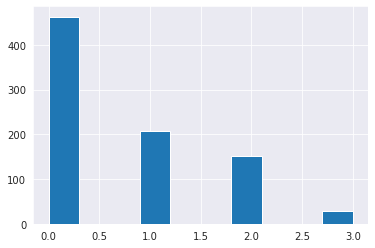

In [53]:
preds = best_rfs[-1].predict(x_scaler.transform(eco_xtest_dfs[-1]))
obs = eco_ytest_dfs[-1]
missed_full = missed_abund_spp(preds, obs)
plt.hist(missed_full.astype(int))

## View scores for regional and global models

In [199]:
for i, region in enumerate(ecoregions[:-1]):
    preds = best_rfs[i].predict(x_scaler.transform(eco_xtest_dfs[i]))
    obs = eco_ytest_dfs[i]
    confusion = confuse_abund_spp(preds, obs)

    confusion_df = pd.DataFrame(confusion, columns=Y_COLS, index=eco_xtest_dfs[i].index)
    confusion_types = ['true_positive', 'true_negative', 'false_positive', 'false_negative', 'total']
    confusion_results = []
    for col in Y_COLS:
        true_positive = len(confusion_df.loc[confusion_df[col] == '11'])
        true_negative = len(confusion_df.loc[confusion_df[col] == '00'])
        false_positive = len(confusion_df.loc[confusion_df[col] == '10'])
        false_negative = len(confusion_df.loc[confusion_df[col] == '01'])
        total = len(confusion_df)
        confusion_results.append(pd.Series([true_positive, true_negative, false_positive, false_negative, total], name=col, index=confusion_types))    

    confusion_matrix = pd.concat(confusion_results, axis=1)
    

    accuracy = (confusion_matrix.loc[['true_positive', 'true_negative']].sum() / confusion_matrix.loc[['total']].sum()).to_frame().T.rename({0: 'accuracy'})
    sensitivity = confusion_matrix.loc[['true_positive']] / confusion_matrix.loc[['true_positive', 'false_negative']].sum()
    specificity = confusion_matrix.loc[['true_negative']] / confusion_matrix.loc[['true_negative', 'false_positive']].sum()
    precision = (confusion_matrix.loc[['true_positive']] / confusion_matrix.loc[['true_positive', 'false_positive']].sum()).rename({'true_positive': 'precision'})

    sensitivity = sensitivity.rename({'true_positive': 'sensitivity'})
    specificity = specificity.rename({'true_negative': 'specificity'})
    true_skill = pd.Series((sensitivity.values + specificity.values - 1).ravel(), name='true_skill', index=Y_COLS).to_frame().T

    print('\nRegional Model', region.upper(), '\n')
    display(confusion_matrix)
    display(pd.concat([accuracy, sensitivity, specificity, precision, true_skill])
     .style
     .format('{:.0%}'))


Regional Model BLUE_MOUNTAINS 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,2,0,0,0,0,0,0,10,0,0,0,0,0,3,0
true_negative,17,25,25,25,22,25,25,5,25,24,25,25,25,18,24
false_positive,1,0,0,0,0,0,0,7,0,0,0,0,0,1,0
false_negative,5,0,0,0,3,0,0,3,0,1,0,0,0,3,1
total,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,76%,100%,100%,100%,88%,100%,100%,60%,100%,96%,100%,100%,100%,84%,96%
sensitivity,29%,nan%,nan%,nan%,0%,nan%,nan%,77%,nan%,0%,nan%,nan%,nan%,50%,0%
specificity,94%,100%,100%,100%,100%,100%,100%,42%,100%,100%,100%,100%,100%,95%,100%
precision,67%,nan%,nan%,nan%,nan%,nan%,nan%,59%,nan%,nan%,nan%,nan%,nan%,75%,nan%
true_skill,23%,nan%,nan%,nan%,0%,nan%,nan%,19%,nan%,0%,nan%,nan%,nan%,45%,0%



Regional Model COAST_RANGE 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,0,1,0,0,245,0,0,0,0,0,40,7,0,0,0
true_negative,344,338,337,347,44,343,329,348,348,348,258,316,348,348,348
false_positive,0,0,0,0,52,1,2,0,0,0,22,2,0,0,0
false_negative,4,9,11,1,7,4,17,0,0,0,28,23,0,0,0
total,348,348,348,348,348,348,348,348,348,348,348,348,348,348,348


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,99%,97%,97%,100%,83%,99%,95%,100%,100%,100%,86%,93%,100%,100%,100%
sensitivity,0%,10%,0%,0%,97%,0%,0%,nan%,nan%,nan%,59%,23%,nan%,nan%,nan%
specificity,100%,100%,100%,100%,46%,100%,99%,100%,100%,100%,92%,99%,100%,100%,100%
precision,nan%,100%,nan%,nan%,82%,0%,0%,nan%,nan%,nan%,65%,78%,nan%,nan%,nan%
true_skill,0%,10%,0%,0%,43%,-0%,-1%,nan%,nan%,nan%,51%,23%,nan%,nan%,nan%



Regional Model EASTERN_CASCADES_SLOPES_AND_FOOTHILLS 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,10,3,0,0,19,0,0,24,0,2,0,0,0,0,0
true_negative,54,79,84,84,46,80,84,43,83,78,82,83,84,84,80
false_positive,11,0,0,0,7,0,0,16,0,0,0,0,0,0,0
false_negative,9,2,0,0,12,4,0,1,1,4,2,1,0,0,4
total,84,84,84,84,84,84,84,84,84,84,84,84,84,84,84


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,76%,98%,100%,100%,77%,95%,100%,80%,99%,95%,98%,99%,100%,100%,95%
sensitivity,53%,60%,nan%,nan%,61%,0%,nan%,96%,0%,33%,0%,0%,nan%,nan%,0%
specificity,83%,100%,100%,100%,87%,100%,100%,73%,100%,100%,100%,100%,100%,100%,100%
precision,48%,100%,nan%,nan%,73%,nan%,nan%,60%,nan%,100%,nan%,nan%,nan%,nan%,nan%
true_skill,36%,60%,nan%,nan%,48%,0%,nan%,69%,0%,33%,0%,0%,nan%,nan%,0%



Regional Model NORTH_CASCADES 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,2,0,0,0,37,0,0,4,0,3,32,0,0,0,0
true_negative,103,109,111,111,45,107,105,99,111,107,60,99,111,111,109
false_positive,1,0,0,0,25,0,0,3,0,1,13,0,0,0,0
false_negative,5,2,0,0,4,4,6,5,0,0,6,12,0,0,2
total,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,95%,98%,100%,100%,74%,96%,95%,93%,100%,99%,83%,89%,100%,100%,98%
sensitivity,29%,0%,nan%,nan%,90%,0%,0%,44%,nan%,100%,84%,0%,nan%,nan%,0%
specificity,99%,100%,100%,100%,64%,100%,100%,97%,100%,99%,82%,100%,100%,100%,100%
precision,67%,nan%,nan%,nan%,60%,nan%,nan%,57%,nan%,75%,71%,nan%,nan%,nan%,nan%
true_skill,28%,0%,nan%,nan%,55%,0%,0%,42%,nan%,99%,66%,0%,nan%,nan%,0%



Regional Model CASCADES 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,10,0,0,0,96,0,0,0,0,0,2,3,0,0,0
true_negative,135,155,159,159,18,159,152,157,159,157,127,141,159,159,159
false_positive,5,0,0,0,43,0,0,0,0,0,2,1,0,0,0
false_negative,9,4,0,0,2,0,7,2,0,2,28,14,0,0,0
total,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,91%,97%,100%,100%,72%,100%,96%,99%,100%,99%,81%,91%,100%,100%,100%
sensitivity,53%,0%,nan%,nan%,98%,nan%,0%,0%,nan%,0%,7%,18%,nan%,nan%,nan%
specificity,96%,100%,100%,100%,30%,100%,100%,100%,100%,100%,98%,99%,100%,100%,100%
precision,67%,nan%,nan%,nan%,69%,nan%,nan%,nan%,nan%,nan%,50%,75%,nan%,nan%,nan%
true_skill,49%,0%,nan%,nan%,27%,nan%,0%,0%,nan%,0%,5%,17%,nan%,nan%,nan%



Regional Model KLAMATH_MOUNTAINS_CALIFORNIA_HIGH_NORTH_COAST_RANGE 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,0,1,0,0,51,0,0,0,0,0,0,0,3,0,0
true_negative,62,52,63,63,0,63,60,63,61,63,62,63,56,63,63
false_positive,0,1,0,0,12,0,0,0,0,0,0,0,1,0,0
false_negative,1,9,0,0,0,0,3,0,2,0,1,0,3,0,0
total,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,98%,84%,100%,100%,81%,100%,95%,100%,97%,100%,98%,100%,94%,100%,100%
sensitivity,0%,10%,nan%,nan%,100%,nan%,0%,nan%,0%,nan%,0%,nan%,50%,nan%,nan%
specificity,100%,98%,100%,100%,0%,100%,100%,100%,100%,100%,100%,100%,98%,100%,100%
precision,nan%,50%,nan%,nan%,81%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,75%,nan%,nan%
true_skill,0%,8%,nan%,nan%,0%,nan%,0%,nan%,0%,nan%,0%,nan%,48%,nan%,nan%



Regional Model NORTHERN_ROCKIES 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0
true_negative,23,25,27,27,5,27,23,22,27,27,26,27,27,27,25
false_positive,2,0,0,0,11,0,0,0,0,0,0,0,0,0,0
false_negative,2,2,0,0,1,0,4,5,0,0,1,0,0,0,2
total,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,85%,93%,100%,100%,56%,100%,85%,81%,100%,100%,96%,100%,100%,100%,93%
sensitivity,0%,0%,nan%,nan%,91%,nan%,0%,0%,nan%,nan%,0%,nan%,nan%,nan%,0%
specificity,92%,100%,100%,100%,31%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%
precision,0%,nan%,nan%,nan%,48%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%
true_skill,-8%,0%,nan%,nan%,22%,nan%,0%,0%,nan%,nan%,0%,nan%,nan%,nan%,0%



Regional Model PUGET_LOWLAND 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,0,0,0,0,19,0,0,0,0,0,1,0,0,0,0
true_negative,30,25,30,30,1,30,25,30,30,29,24,26,30,30,30
false_positive,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0
false_negative,0,5,0,0,0,0,5,0,0,1,5,4,0,0,0
total,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,100%,83%,100%,100%,67%,100%,83%,100%,100%,97%,83%,87%,100%,100%,100%
sensitivity,nan%,0%,nan%,nan%,100%,nan%,0%,nan%,nan%,0%,17%,0%,nan%,nan%,nan%
specificity,100%,100%,100%,100%,9%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%
precision,nan%,nan%,nan%,nan%,66%,nan%,nan%,nan%,nan%,nan%,100%,nan%,nan%,nan%,nan%
true_skill,nan%,0%,nan%,nan%,9%,nan%,0%,nan%,nan%,0%,17%,0%,nan%,nan%,nan%



Regional Model WILLAMETTE_VALLEY 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0
true_negative,3,3,3,3,0,3,3,3,3,3,3,3,3,3,3
false_positive,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
false_negative,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
total,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%
sensitivity,nan%,nan%,nan%,nan%,100%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%
specificity,100%,100%,100%,100%,nan%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%
precision,nan%,nan%,nan%,nan%,100%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%
true_skill,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%


In [200]:
for i, region in enumerate(ecoregions):
    preds = best_rfs[i].predict(x_scaler.transform(eco_xtest_dfs[i]))
    obs = eco_ytest_dfs[i]
    confusion = confuse_abund_spp(preds, obs)

    confusion_df = pd.DataFrame(confusion, columns=Y_COLS, index=eco_xtest_dfs[i].index)
    confusion_types = ['true_positive', 'true_negative', 'false_positive', 'false_negative', 'total']
    confusion_results = []
    for col in Y_COLS:
        true_positive = len(confusion_df.loc[confusion_df[col] == '11'])
        true_negative = len(confusion_df.loc[confusion_df[col] == '00'])
        false_positive = len(confusion_df.loc[confusion_df[col] == '10'])
        false_negative = len(confusion_df.loc[confusion_df[col] == '01'])
        total = len(confusion_df)
        confusion_results.append(pd.Series([true_positive, true_negative, false_positive, false_negative, total], name=col, index=confusion_types))    

    confusion_matrix = pd.concat(confusion_results, axis=1)
    

    accuracy = (confusion_matrix.loc[['true_positive', 'true_negative']].sum() / confusion_matrix.loc[['total']].sum()).to_frame().T.rename({0: 'accuracy'})
    sensitivity = confusion_matrix.loc[['true_positive']] / confusion_matrix.loc[['true_positive', 'false_negative']].sum()
    specificity = confusion_matrix.loc[['true_negative']] / confusion_matrix.loc[['true_negative', 'false_positive']].sum()
    precision = (confusion_matrix.loc[['true_positive']] / confusion_matrix.loc[['true_positive', 'false_positive']].sum()).rename({'true_positive': 'precision'})

    sensitivity = sensitivity.rename({'true_positive': 'sensitivity'})
    specificity = specificity.rename({'true_negative': 'specificity'})
    true_skill = pd.Series((sensitivity.values + specificity.values - 1).ravel(), name='true_skill', index=Y_COLS).to_frame().T

    print('\nGlobal Model', region.upper(), '\n')
    display(confusion_matrix)
    display(pd.concat([accuracy, sensitivity, specificity, precision, true_skill])
     .style
     .format('{:.0%}'))


Global Model BLUE_MOUNTAINS 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,2,0,0,0,0,0,0,10,0,0,0,0,0,3,0
true_negative,17,25,25,25,22,25,25,5,25,24,25,25,25,18,24
false_positive,1,0,0,0,0,0,0,7,0,0,0,0,0,1,0
false_negative,5,0,0,0,3,0,0,3,0,1,0,0,0,3,1
total,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,76%,100%,100%,100%,88%,100%,100%,60%,100%,96%,100%,100%,100%,84%,96%
sensitivity,29%,nan%,nan%,nan%,0%,nan%,nan%,77%,nan%,0%,nan%,nan%,nan%,50%,0%
specificity,94%,100%,100%,100%,100%,100%,100%,42%,100%,100%,100%,100%,100%,95%,100%
precision,67%,nan%,nan%,nan%,nan%,nan%,nan%,59%,nan%,nan%,nan%,nan%,nan%,75%,nan%
true_skill,23%,nan%,nan%,nan%,0%,nan%,nan%,19%,nan%,0%,nan%,nan%,nan%,45%,0%



Global Model COAST_RANGE 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,0,1,0,0,245,0,0,0,0,0,40,7,0,0,0
true_negative,344,338,337,347,44,343,329,348,348,348,258,316,348,348,348
false_positive,0,0,0,0,52,1,2,0,0,0,22,2,0,0,0
false_negative,4,9,11,1,7,4,17,0,0,0,28,23,0,0,0
total,348,348,348,348,348,348,348,348,348,348,348,348,348,348,348


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,99%,97%,97%,100%,83%,99%,95%,100%,100%,100%,86%,93%,100%,100%,100%
sensitivity,0%,10%,0%,0%,97%,0%,0%,nan%,nan%,nan%,59%,23%,nan%,nan%,nan%
specificity,100%,100%,100%,100%,46%,100%,99%,100%,100%,100%,92%,99%,100%,100%,100%
precision,nan%,100%,nan%,nan%,82%,0%,0%,nan%,nan%,nan%,65%,78%,nan%,nan%,nan%
true_skill,0%,10%,0%,0%,43%,-0%,-1%,nan%,nan%,nan%,51%,23%,nan%,nan%,nan%



Global Model EASTERN_CASCADES_SLOPES_AND_FOOTHILLS 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,10,3,0,0,19,0,0,24,0,2,0,0,0,0,0
true_negative,54,79,84,84,46,80,84,43,83,78,82,83,84,84,80
false_positive,11,0,0,0,7,0,0,16,0,0,0,0,0,0,0
false_negative,9,2,0,0,12,4,0,1,1,4,2,1,0,0,4
total,84,84,84,84,84,84,84,84,84,84,84,84,84,84,84


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,76%,98%,100%,100%,77%,95%,100%,80%,99%,95%,98%,99%,100%,100%,95%
sensitivity,53%,60%,nan%,nan%,61%,0%,nan%,96%,0%,33%,0%,0%,nan%,nan%,0%
specificity,83%,100%,100%,100%,87%,100%,100%,73%,100%,100%,100%,100%,100%,100%,100%
precision,48%,100%,nan%,nan%,73%,nan%,nan%,60%,nan%,100%,nan%,nan%,nan%,nan%,nan%
true_skill,36%,60%,nan%,nan%,48%,0%,nan%,69%,0%,33%,0%,0%,nan%,nan%,0%



Global Model NORTH_CASCADES 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,2,0,0,0,37,0,0,4,0,3,32,0,0,0,0
true_negative,103,109,111,111,45,107,105,99,111,107,60,99,111,111,109
false_positive,1,0,0,0,25,0,0,3,0,1,13,0,0,0,0
false_negative,5,2,0,0,4,4,6,5,0,0,6,12,0,0,2
total,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,95%,98%,100%,100%,74%,96%,95%,93%,100%,99%,83%,89%,100%,100%,98%
sensitivity,29%,0%,nan%,nan%,90%,0%,0%,44%,nan%,100%,84%,0%,nan%,nan%,0%
specificity,99%,100%,100%,100%,64%,100%,100%,97%,100%,99%,82%,100%,100%,100%,100%
precision,67%,nan%,nan%,nan%,60%,nan%,nan%,57%,nan%,75%,71%,nan%,nan%,nan%,nan%
true_skill,28%,0%,nan%,nan%,55%,0%,0%,42%,nan%,99%,66%,0%,nan%,nan%,0%



Global Model CASCADES 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,10,0,0,0,96,0,0,0,0,0,2,3,0,0,0
true_negative,135,155,159,159,18,159,152,157,159,157,127,141,159,159,159
false_positive,5,0,0,0,43,0,0,0,0,0,2,1,0,0,0
false_negative,9,4,0,0,2,0,7,2,0,2,28,14,0,0,0
total,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,91%,97%,100%,100%,72%,100%,96%,99%,100%,99%,81%,91%,100%,100%,100%
sensitivity,53%,0%,nan%,nan%,98%,nan%,0%,0%,nan%,0%,7%,18%,nan%,nan%,nan%
specificity,96%,100%,100%,100%,30%,100%,100%,100%,100%,100%,98%,99%,100%,100%,100%
precision,67%,nan%,nan%,nan%,69%,nan%,nan%,nan%,nan%,nan%,50%,75%,nan%,nan%,nan%
true_skill,49%,0%,nan%,nan%,27%,nan%,0%,0%,nan%,0%,5%,17%,nan%,nan%,nan%



Global Model KLAMATH_MOUNTAINS_CALIFORNIA_HIGH_NORTH_COAST_RANGE 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,0,1,0,0,51,0,0,0,0,0,0,0,3,0,0
true_negative,62,52,63,63,0,63,60,63,61,63,62,63,56,63,63
false_positive,0,1,0,0,12,0,0,0,0,0,0,0,1,0,0
false_negative,1,9,0,0,0,0,3,0,2,0,1,0,3,0,0
total,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,98%,84%,100%,100%,81%,100%,95%,100%,97%,100%,98%,100%,94%,100%,100%
sensitivity,0%,10%,nan%,nan%,100%,nan%,0%,nan%,0%,nan%,0%,nan%,50%,nan%,nan%
specificity,100%,98%,100%,100%,0%,100%,100%,100%,100%,100%,100%,100%,98%,100%,100%
precision,nan%,50%,nan%,nan%,81%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,75%,nan%,nan%
true_skill,0%,8%,nan%,nan%,0%,nan%,0%,nan%,0%,nan%,0%,nan%,48%,nan%,nan%



Global Model NORTHERN_ROCKIES 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0
true_negative,23,25,27,27,5,27,23,22,27,27,26,27,27,27,25
false_positive,2,0,0,0,11,0,0,0,0,0,0,0,0,0,0
false_negative,2,2,0,0,1,0,4,5,0,0,1,0,0,0,2
total,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,85%,93%,100%,100%,56%,100%,85%,81%,100%,100%,96%,100%,100%,100%,93%
sensitivity,0%,0%,nan%,nan%,91%,nan%,0%,0%,nan%,nan%,0%,nan%,nan%,nan%,0%
specificity,92%,100%,100%,100%,31%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%
precision,0%,nan%,nan%,nan%,48%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%
true_skill,-8%,0%,nan%,nan%,22%,nan%,0%,0%,nan%,nan%,0%,nan%,nan%,nan%,0%



Global Model PUGET_LOWLAND 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,0,0,0,0,19,0,0,0,0,0,1,0,0,0,0
true_negative,30,25,30,30,1,30,25,30,30,29,24,26,30,30,30
false_positive,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0
false_negative,0,5,0,0,0,0,5,0,0,1,5,4,0,0,0
total,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,100%,83%,100%,100%,67%,100%,83%,100%,100%,97%,83%,87%,100%,100%,100%
sensitivity,nan%,0%,nan%,nan%,100%,nan%,0%,nan%,nan%,0%,17%,0%,nan%,nan%,nan%
specificity,100%,100%,100%,100%,9%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%
precision,nan%,nan%,nan%,nan%,66%,nan%,nan%,nan%,nan%,nan%,100%,nan%,nan%,nan%,nan%
true_skill,nan%,0%,nan%,nan%,9%,nan%,0%,nan%,nan%,0%,17%,0%,nan%,nan%,nan%



Global Model WILLAMETTE_VALLEY 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0
true_negative,3,3,3,3,0,3,3,3,3,3,3,3,3,3,3
false_positive,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
false_negative,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
total,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%
sensitivity,nan%,nan%,nan%,nan%,100%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%
specificity,100%,100%,100%,100%,nan%,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%
precision,nan%,nan%,nan%,nan%,100%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%
true_skill,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%



Global Model ALL 



,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
true_positive,24,3,0,0,476,0,0,37,0,1,75,6,1,2,0
true_negative,775,813,840,850,176,838,808,770,848,838,672,783,845,844,842
false_positive,17,0,0,0,166,1,1,27,0,0,33,4,0,1,0
false_negative,35,35,11,1,33,12,42,17,3,12,71,58,5,4,9
total,851,851,851,851,851,851,851,851,851,851,851,851,851,851,851


,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
accuracy,94%,96%,99%,100%,77%,98%,95%,95%,100%,99%,88%,93%,99%,99%,99%
sensitivity,41%,8%,0%,0%,94%,0%,0%,69%,0%,8%,51%,9%,17%,33%,0%
specificity,98%,100%,100%,100%,51%,100%,100%,97%,100%,100%,95%,99%,100%,100%,100%
precision,59%,100%,nan%,nan%,74%,0%,0%,58%,nan%,100%,69%,60%,100%,67%,nan%
true_skill,39%,8%,0%,0%,45%,-0%,-0%,65%,0%,8%,47%,9%,17%,33%,0%


In [202]:
confusion_df.loc[confusion_df['MAPLE'] == '01']

,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
2983,00,00,01,00,10,00,00,00,00,00,00,00,00,00,00
4507,00,00,01,00,10,00,00,00,00,00,00,01,00,00,00
1680,00,00,01,00,11,00,00,00,00,00,00,00,00,00,00
3483,00,00,01,00,10,00,01,00,00,00,00,00,00,00,00
813,00,00,01,00,10,00,00,00,00,00,00,00,00,00,00
1342,00,00,01,00,10,00,00,00,00,00,00,00,00,00,00
4057,00,00,01,00,10,00,00,00,00,00,01,00,00,00,00
3253,00,00,01,00,10,00,00,00,00,00,00,01,00,00,00
1712,00,00,01,00,11,00,00,00,00,00,00,00,00,00,00
1748,00,00,01,00,10,00,00,00,00,00,00,00,00,00,00


In [209]:
pd.DataFrame(obs, index=eco_ytest_dfs[-1].index, columns=Y_COLS).loc[confusion_df.loc[confusion_df['MAPLE'] == '01'].index].astype(int)

,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
2983,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0
4507,0,0,78,0,0,0,0,0,0,0,0,44,0,0,0
1680,0,19,56,0,90,0,0,0,0,0,0,0,0,0,0
3483,0,0,28,0,9,0,26,0,0,0,0,0,0,0,0
813,0,0,138,0,0,0,0,0,0,0,0,0,0,0,0
1342,21,0,130,0,0,0,0,0,0,0,0,0,0,0,0
4057,0,0,19,0,0,0,0,0,0,0,24,0,0,0,0
3253,0,0,48,0,0,0,0,0,0,0,0,94,0,0,0
1712,0,0,46,0,76,0,13,0,0,0,0,0,0,0,0
1748,0,0,113,0,0,0,0,0,0,0,0,0,0,0,0


In [208]:
pd.DataFrame(preds, index=eco_xtest_dfs[-1].index, columns=Y_COLS).loc[confusion_df.loc[confusion_df['MAPLE'] == '01'].index].astype(int)

,TRUE_FIR,OTHER_HARDWOOD,MAPLE,OAK,DOUGLAS_FIR,SPRUCE,CEDAR,PONDEROSA_PINE,OTHER_SOFTWOOD,LODGEPOLE_PINE,HEMLOCK,RED_ALDER,TANOAK,JUNIPER,LARCH
2983,3,7,14,0,114,0,13,0,0,0,16,15,1,0,0
4507,1,5,19,0,79,0,9,0,0,0,15,16,0,0,0
1680,4,5,5,0,79,0,3,0,0,0,10,3,1,0,0
3483,3,6,12,0,81,0,11,0,0,0,17,20,0,0,0
813,7,9,10,0,80,0,12,0,0,0,13,13,1,0,0
1342,5,6,16,0,112,0,19,0,0,0,23,15,1,0,0
4057,4,4,20,0,162,0,25,0,0,0,30,5,0,0,0
3253,2,2,33,0,82,0,3,0,0,0,14,43,1,0,0
1712,3,5,14,0,53,0,11,0,0,0,12,11,1,0,0
1748,5,8,29,0,129,0,15,0,0,0,23,8,1,0,0


In [ ]:
### Employing feature selection to try and improve random forest regression

In [ ]:
importances = best_rfs[-1].feature_importances_
indices = np.argsort(importances)[::-1]
features = eco_xtrain_dfs[-1].columns[indices]

# Print the feature ranking
print("Feature ranking:")

for f in range(eco_xtrain_dfs[-1].shape[1]):
    print("%d. %s (%f)" % (f+1, features[f], importances[indices[f]]))

In [ ]:
### Employing feature selection to try and improve support vector regression

In [ ]:
MODELS = {'ElasticNet': best_lms, 
          'LASSO': best_lassos,
          'LASSO_{}'.format(MAX_FEATURES): trimmed_lassos,
          'KNN': best_knns,
          'RF': best_rfs,
          'GB': best_gbs,
          'SVM': best_svms}

def scatter_graphs(model_dict):
    names = MODELS.keys()
    EXTEND_PCT = 0.10
    
    fig, axs = plt.subplots(len(ecoregion_names), len(names), 
                            sharex=True, sharey=True,
                            figsize=(12,15)
                           )
    
    all_obs = transformer.inverse_transform(eco_ytest_dfs[-1].reshape(-1,1))
    obs_min = all_obs.min()
    obs_max = all_obs.max()
    rng = obs_max - obs_min
        
    for i, ecoreg in enumerate(ecoregion_names):
        observed = transformer.inverse_transform(eco_ytest_dfs[i].reshape(-1,1))
        
        for j, name in enumerate(names):
            axs[0,j].set_title(name)
            axs[i,0].set_ylabel(ecoreg)
            axs[i,j].set_xlim(obs_min - EXTEND_PCT*rng, obs_max + EXTEND_PCT*rng)
            axs[i,j].set_ylim(obs_min - EXTEND_PCT*rng, obs_max + EXTEND_PCT*rng)
            axs[i,j].set_aspect('equal')
            
            if name == 'LASSO_{}'.format(MAX_FEATURES):
                predicted = MODELS[name][-1].predict(sfms[-1].transform(x_scaler.transform(eco_xtest_dfs[i])))
            else:
                predicted = MODELS[name][-1].predict(x_scaler.transform(eco_xtest_dfs[i]))
            
            predicted = transformer.inverse_transform(predicted.reshape(-1,1))
            axs[i,j].scatter(observed, predicted, s=0.5)
            axs[i,j].plot((obs_min - EXTEND_PCT*rng, obs_max + EXTEND_PCT*rng), 
                          (obs_min - EXTEND_PCT*rng, obs_max + EXTEND_PCT*rng),
                         color='k', lw=0.5)
            
    plt.tight_layout(pad=0.001)

In [ ]:
MODELS = {'ElasticNet': best_lms, 
          'LASSO': best_lassos,
          'LASSO_{}'.format(MAX_FEATURES): trimmed_lassos,
          'KNN': best_knns,
          'RF': best_rfs,
          'GB': best_gbs,
          'SVM': best_svms}

scatter_graphs(MODELS)

In [ ]:
METRIC = 'growing_stock_tpa'

MODELS = {'ElasticNet': best_lms,
          'LASSO': best_lassos,
          'LASSO{}'.format(MAX_FEATURES): trimmed_lassos,
          'KNN': best_knns,
          'RF': best_rfs,
          'GB': best_gbs,
          'SVM': best_svms}

pickle.dump(x_scaler, 
            open('../models/{}/sklearn/x_scaler.pkl'.format(METRIC), 'wb'))
pickle.dump(transformer, 
            open('../models/{}/sklearn/y_scaler.pkl'.format(METRIC), 'wb'))

for i in range(len(ecoregion_names)):
    for key in MODELS.keys():
        fname = ecoregion_names[i] + '_{}.pkl'.format(key)
        path_to_file = '../models/{}/sklearn/{}'.format(METRIC, fname)
        pickle.dump(MODELS[key][i], 
                    open(path_to_file, 'wb'))
        
        if key == 'LASSO{}'.format(MAX_FEATURES):
            sfm_name = ecoregion_names[i] + '_LASSO{}_featureselect.pkl'.format(MAX_FEATURES)
            path_to_file = '../models/{}/sklearn/{}'.format(METRIC, sfm_name)
            pickle.dump(sfms[i], 
                        open(path_to_file, 'wb'))